# M5 Forecast: Poisson loss (top 10%)

This very simple script was lucky enough to get top 10% in private lb. 

I moved the time horizon of the previous version of this notebook by 28 days and removed all "magic" stuff. The winning solutions did clearly better in terms of performance, but simplicity is worth a lot when it comes to maintainance etc.

In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb

In [2]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU Details:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # True nếu TensorFlow có hỗ trợ CUDA
print(tf.config.list_physical_devices('GPU'))  # True nếu GPU có thể sử dụng

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf

# Kiểm tra các thiết bị TensorFlow có thể sử dụng
print("Available devices:")
print(tf.config.list_logical_devices())

# Kiểm tra TensorFlow có đang chạy trên GPU không
print("Default GPU Device:", tf.test.gpu_device_name())

Available devices:
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Chỉ cho phép TensorFlow sử dụng GPU đầu tiên
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

# Kiểm tra lại thiết bị đang sử dụng
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a + b
    print(c)

Physical devices cannot be modified after being initialized
tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)


In [6]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())  # Phải trả về True
print(tf.config.list_physical_devices('GPU'))  # Phải có ít nhất một GPU

2.10.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
import tensorflow as tf
import time

# Kiểm tra GPU có hoạt động không
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Kích thước ma trận lớn
MATRIX_SIZE = 10000

# Hàm đo thời gian thực thi trên GPU/CPU
def benchmark_matmul(device):
    with tf.device(device):
        print(f"Running on {device}...")
        a = tf.random.uniform((MATRIX_SIZE, MATRIX_SIZE), minval=0, maxval=1)
        b = tf.random.uniform((MATRIX_SIZE, MATRIX_SIZE), minval=0, maxval=1)
        
        # Đo thời gian nhân ma trận
        start_time = time.time()
        c = tf.matmul(a, b)
        tf.experimental.numpy.copy(c)  # Đảm bảo phép toán được thực thi
        end_time = time.time()
        
        print(f"Time taken on {device}: {end_time - start_time:.4f} seconds")

# Chạy trên CPU
benchmark_matmul('/CPU:0')

# Chạy trên GPU nếu có
if tf.config.list_physical_devices('GPU'):
    benchmark_matmul('/GPU:0')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Running on /CPU:0...
Time taken on /CPU:0: 3.4244 seconds
Running on /GPU:0...
Time taken on /GPU:0: 0.0000 seconds


## Load data

In [9]:
path = "./m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv"))

## Prepare calendar data

In [10]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [11]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif str(t) == 'object':
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [12]:
# Calculate memory usage before running the function
memory_before = {
    'calendar': calendar.memory_usage(deep=True).sum(),
    'sales': sales.memory_usage(deep=True).sum(),
    'prices': selling_prices.memory_usage(deep=True).sum()
}

sales = downcast(sales)
prices = downcast(selling_prices)
calendar = downcast(calendar)

memory_after = {
    'calendar': calendar.memory_usage(deep=True).sum(),
    'sales': sales.memory_usage(deep=True).sum(),
    'prices': prices.memory_usage(deep=True).sum()
}

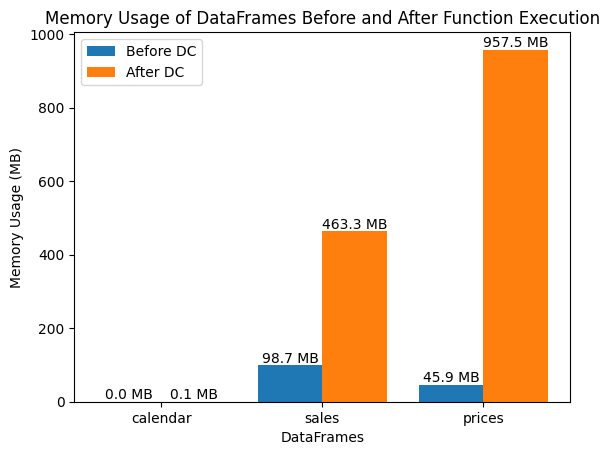

In [13]:
import matplotlib.pyplot as plt
# Convert memory usage to MB and format to 2 decimal places
memory_before_mb = {key: round(value / (1024 ** 2), 1) for key, value in memory_before.items()}
memory_after_mb = {key: round(value / (1024 ** 2), 1) for key, value in memory_after.items()}

# Plotting the memory usage
labels = list(memory_before_mb.keys())
before_values = list(memory_before_mb.values())
after_values = list(memory_after_mb.values())

x = range(len(labels))
w = 0.4

plt.bar(x, after_values, width=w, label='Before DC', align='center')
plt.bar([p + w for p in x], before_values, width=w, label='After DC', align='center')

# Adding values on top of the columns
for i in range(len(labels)):
    plt.text(i, after_values[i], f'{after_values[i]:.1f} MB', ha='center', va='bottom')
    plt.text(i + w, before_values[i], f'{before_values[i]:.1f} MB', ha='center', va='bottom')

plt.xlabel('DataFrames')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage of DataFrames Before and After Function Execution')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.show()

## Helper functions

We need the following functions.

In [14]:
from sklearn.model_selection import train_test_split

LAGS = [7, 28]
WINDOWS = [7, 28]
FIRST = 1942 # first to predict
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

def prep_data(df, drop_d=1000):
    """ Prepare model data sets """
    
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(drop_d)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_evaluation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id", "dept_id", "cat_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    
    # Add demand features
    df = demand_features(df)
    
    # Remove rows with NAs
    df = df[df.d > (drop_d + max(LAGS) + max(WINDOWS))]
 
    # Join calendar & prices
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)
    
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id", "dept_id", "cat_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
            
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS) - 28]
    df = df[df.d < FIRST]

    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)

    return train, valid, test, x

def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.08,
        'lambda': 0.1,
        'num_leaves': 63,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.7
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 2000, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

def pred_all(fit, test, x):
    """ Calculate predictions """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x])
    
    return test

def pred_to_csv(test, cols=sample_submission.columns, file="submission.csv"):
    """ Reshape predictions and save submission csv """
     
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + LENGTH + 1 - LENGTH * (test.d >= FIRST)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

## Run the code

In [15]:
import gc

# Force garbage collection
gc.collect()

3455

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Chỉ dùng GPU số 0

c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 25053633, number of used features: 20
[LightGBM] [Info] Start training from score 0.206062
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.25724
[200]	valid_0's rmse: 2.22905
[300]	valid_0's rmse: 2.20597
[400]	valid_0's rmse: 2.19306
[500]	valid_0's rmse: 2.18202
[600]	valid_0's rmse: 2.17354
[700]	valid_0's rmse: 2.16965
[800]	valid_0's rmse: 2.16431
[900]	valid_0's rmse: 2.15834
[1000]	valid_0's rmse: 2.1535
[1100]	valid_0's rmse: 2.15099
[1200]	valid_0's rmse: 2.14827
[1300]	valid_0's rmse: 2.14425
[1400]	valid_0's rmse: 2.14074
[1500]	valid_0's rmse: 2.13829
[1600]	valid_0's rmse: 2.13622
[1700]	valid_0's rmse: 2.13363
[1800]	valid_0's rmse: 2.13198
[1900]	valid_0's rmse: 2.13029
[2000]	valid_0's rmse: 2.12839
Did not meet early stopping. Best iteration is:
[1996]	valid_0's rmse: 2.12826


True

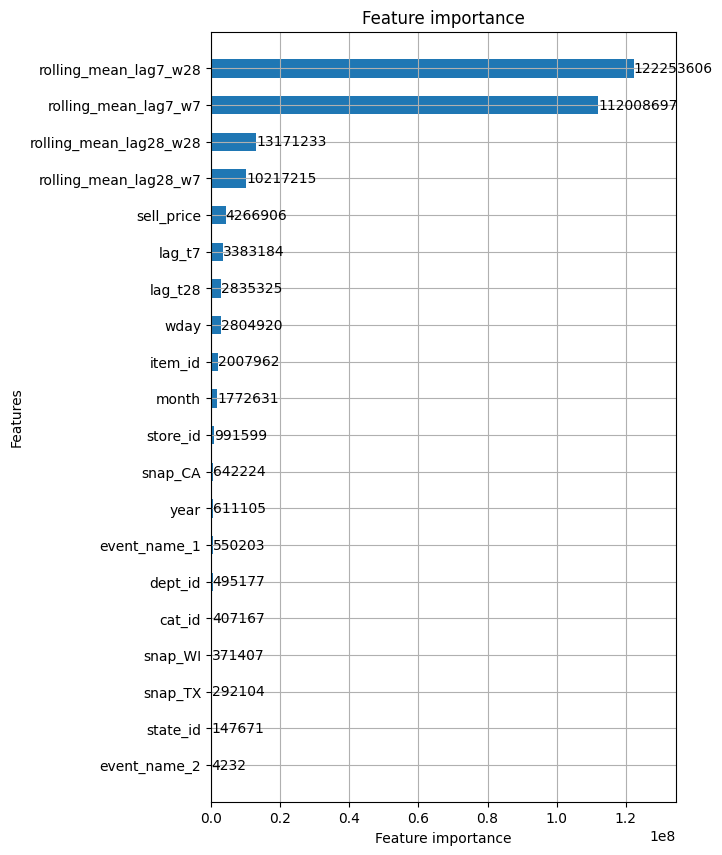

In [16]:
train, valid, test, x = prep_data(sales, 1000 - 28)
fit = fit_model(train, valid)
pred = pred_all(fit, test, x)
pred_to_csv(pred, cols=sample_submission.columns, file="submission.csv")

In [17]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU Details:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
